Taken from https://cfml.se/blog/temporal_difference_learning/ and modified/annotated

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from enum import Enum

### Configurations

In [2]:
# fixing seed for now, in order to get a feel for hyperparameter sensitivity
np.random.seed(0)

## Defining Classes and Functions

In [3]:
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

In [4]:
class Environment:
    def __init__(self, starting_state):
        # set up wind factor for each column, as well as goal state
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.goal = (7, 3)
        self.state = starting_state

    def adjust_position(self):
        if self.state[0] < 0:
            self.state = (0, self.state[1])
        elif self.state[0] > 9:
            self.state = (9, self.state[1])

        if self.state[1] < 0:
            self.state = (self.state[0], 0)
        elif self.state[1] > 6:
            self.state = (self.state[0], 6)

    def take_action(self, action):
        if action == Action.UP:
            self.state = (self.state[0], self.state[1] + 1)
        elif action == Action.DOWN:
            self.state = (self.state[0], self.state[1] - 1)
        elif action == Action.LEFT:
            self.state = (self.state[0] - 1, self.state[1])
        elif action == Action.RIGHT:
            self.state = (self.state[0] + 1, self.state[1])
        else:
            print('ERROR: Unexpected State!')
        self.adjust_position()

        # take wind into account
        if self.state != self.goal:
            self.state = (self.state[0], self.state[1] + self.wind[self.state[0]])
            self.adjust_position()

        if self.state == self.goal:
            return 0
        return -1

In [5]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, reducing_epsilon=False):
        self.alpha = alpha
        self.epsilon = epsilon
        
        # set up 3D array of a 10x7 Windy Grid board with values of transitions in
        # each direction (Up-Down-Left-Right) from each state along the 4-dim z-axis
        self.Q = np.zeros((10, 7, 4))

    def step(self, environment):
        # get current state (position on board)
        s = environment.state
        
        # select action to take based on current policy 
        a = epsilon_greedy(self.epsilon, self.Q, s)

        # take action and return reward
        r = environment.take_action(Action(a))
        
        # update state (new position on board after action)
        s_prime = environment.state

        # update Q for the state the agent has just transitioned from, based on the best estimated
        # action which could potentially have been taken, and which would have been taken if using
        # an epsilon value of 0 (being fully greedy)
        self.Q[s[0], s[1], a] += self.alpha * (
            r + np.max(self.Q[s_prime[0], s_prime[1], :]) - self.Q[s[0], s[1], a]
        )

        # checking if goal has been reached
        if r == 0:
            return True
        return False
    
    def reduce_epsilon(self):
        # halve the magnitude of epsilon to curtail exploration
        self.epsilon = self.epsilon / 2

In [6]:
def epsilon_greedy(epsilon, Q, s):
    # returns the index of the z-axis component of the current state which has the
    # highest value -- which action (direction to move) is the best option
    a = np.argmax(Q[s[0], s[1], :])
    
    # curtails the greediness to ensure there is some chance of exploration away
    # from the current best known path (lower epsilon means more greedy)
    if np.random.rand() < epsilon:
        a = np.random.randint(0, 4)
    return a

## Testing

### Different  $\epsilon$ values

Below is a comparison of how total step counts to the goal reduces per episode for $\epsilon$ values of `0.1` and `0.3`.

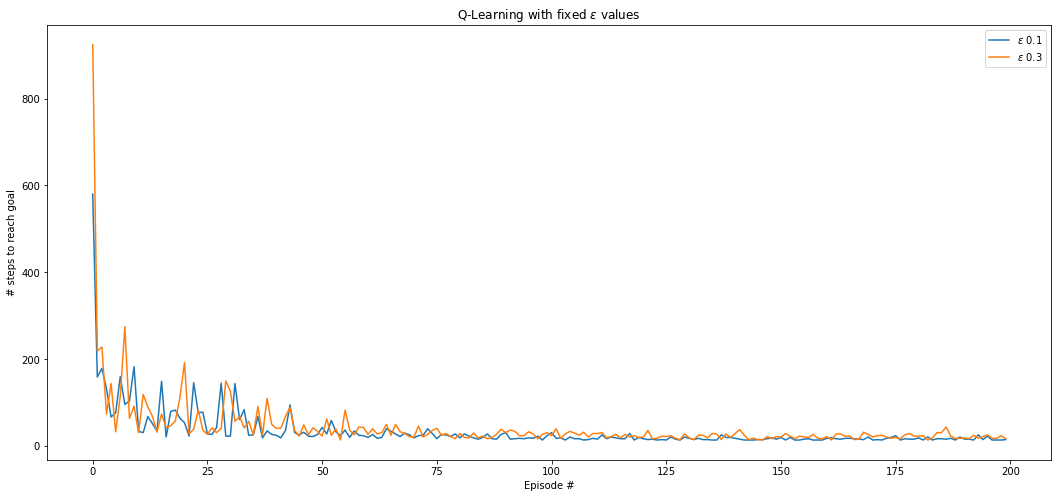

In [7]:
NUM_EPISODES = 200
MAX_NUM_STEPS = 1000
ALPHA = 0.5
EPSILONS = [0.1, 0.3]
STARTING_STATE = (0, 3)
REDUCING_EPSILON = False

agents = [QLearningAgent(ALPHA, epsilon, REDUCING_EPSILON) for epsilon in EPSILONS]
num_steps = np.zeros((len(agents), NUM_EPISODES))

for agent_index, agent in enumerate(agents):
    for episode in range(NUM_EPISODES):
        environment = Environment(STARTING_STATE)
        for num_steps[agent_index, episode] in range(MAX_NUM_STEPS):
            at_goal = agent.step(environment)
            if at_goal:
                break
                
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(range(NUM_EPISODES), num_steps[0, :], label='$\epsilon$ 0.1')
plt.plot(range(NUM_EPISODES), num_steps[1, :], label='$\epsilon$ 0.3')
plt.title('Q-Learning with fixed $\epsilon$ values')
plt.legend()
plt.xlabel('Episode #')
plt.ylabel('# steps to reach goal')
plt.show()

As can be seen in the plot above, when it looks as though convergence has essentially been reached, the occasional exploration means that even the agent with $\epsilon$ of `0.1` is unlikely to ever *actually* converge.

### Varying  $\epsilon$ during learning

And here is a comparison of how total step counts to the goal reduces per episode for $\epsilon$ values of `0.1` and `0.3`, where $\epsilon$ is halved whenever the step count remains unchanged for five consecutive episodes.

In [8]:
NUM_EPISODES = 200
MAX_NUM_STEPS = 1000
ALPHA = 0.5
EPSILONS = [0.1, 0.3]
STARTING_STATE = (0, 3)
REDUCING_EPSILON = True

agents = [QLearningAgent(ALPHA, epsilon, REDUCING_EPSILON) for epsilon in EPSILONS]
num_steps = np.zeros((len(agents), NUM_EPISODES))

# have added a double-ended queue to represent a sliding window with the five most
# recent step totals.  if the total is the same for five episodes in a row, this
# indicates that convergenge may have occured, and epsilon is then halved in order
# to reduce exploration (but never to zero), and the sliding window process is reset

for agent_index, agent in enumerate(agents):
    recent_step_total = deque([1,2,3,4,5], maxlen=5)
    for episode in range(NUM_EPISODES):
        if REDUCING_EPSILON and (len(set(recent_step_total))):
            # evaluates to true when five step consecutive step totals are the same
            agent.reduce_epsilon() # halve epsilon to curtail exploration
            recent_step_total = deque([1,2,3,4,5], maxlen=5) # reset queue
        environment = Environment(STARTING_STATE)
        for num_steps[agent_index, episode] in range(MAX_NUM_STEPS):
            at_goal = agent.step(environment)
            if at_goal:
                recent_step_total.appendleft(num_steps[agent_index, episode])
                break
                
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(NUM_EPISODES), num_steps[0, :], label='$\epsilon$ 0.1')
plt.plot(range(NUM_EPISODES), num_steps[1, :], label='$\epsilon$ 0.3')
plt.title('Q-Learning with variable $\epsilon$ values')
plt.legend()
plt.xlabel('Episode #')
plt.ylabel('# steps to reach goal')
plt.show()

From this plot, even the agent with variable $\epsilon$ of `0.3` converges quicker than the `0.1` agent with fixed $\epsilon$ from the previous plot.

### Different  $\alpha$ values

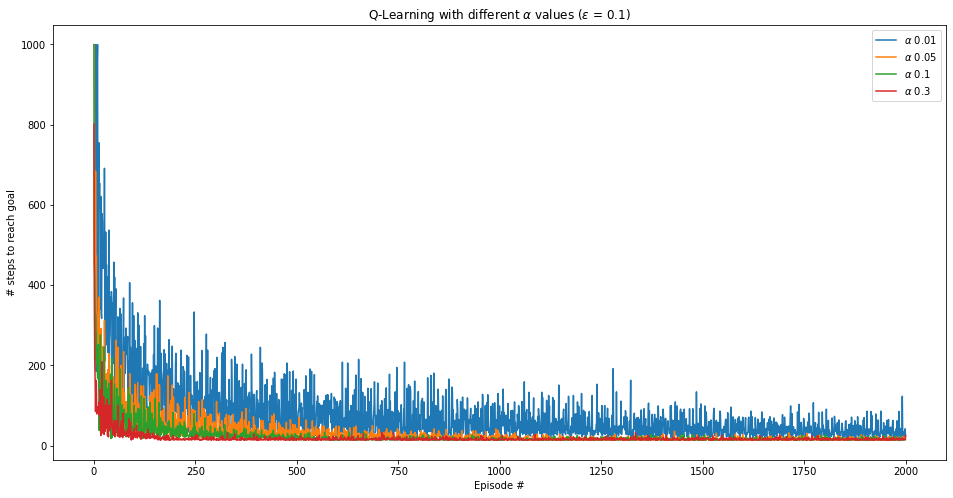

In [9]:
NUM_EPISODES = 2000
MAX_NUM_STEPS = 1000
ALPHAS = [0.01, 0.05, 0.1, 0.3]
EPSILONS = [0.1, 0.3]
STARTING_STATE = (0, 3)
REDUCING_EPSILON = False

agents = [QLearningAgent(alpha, EPSILONS[0], REDUCING_EPSILON) for alpha in ALPHAS]
num_steps = np.zeros((len(agents), NUM_EPISODES))

for agent_index, agent in enumerate(agents):
    for episode in range(NUM_EPISODES):
        environment = Environment(STARTING_STATE)
        for num_steps[agent_index, episode] in range(MAX_NUM_STEPS):
            at_goal = agent.step(environment)
            if at_goal:
                break
                
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(NUM_EPISODES), num_steps[0, :], label='$\\alpha$ 0.01')
plt.plot(range(NUM_EPISODES), num_steps[1, :], label='$\\alpha$ 0.05')
plt.plot(range(NUM_EPISODES), num_steps[2, :], label='$\\alpha$ 0.1')
plt.plot(range(NUM_EPISODES), num_steps[3, :], label='$\\alpha$ 0.3')
plt.title('Q-Learning with different $\\alpha$ values ($\epsilon$ = 0.1)')
plt.legend()
plt.xlabel('Episode #')
plt.ylabel('# steps to reach goal')
plt.show()

## Path Visualisation

In [10]:
new_array = np.rot90(np.round(np.argmax(agent.Q, axis=2)))
print(new_array)

[[0 3 3 3 3 3 3 3 3 1]
 [3 3 3 3 3 3 3 0 3 1]
 [3 3 3 3 3 3 0 1 3 1]
 [3 3 3 3 3 3 0 0 2 1]
 [3 3 3 3 3 0 0 0 2 2]
 [1 3 3 3 0 0 0 0 2 1]
 [0 3 3 0 0 0 0 0 0 2]]


In [11]:
d = {0: '^', 1: 'v', 2: '<', 3: '>'}
_x = np.vectorize(d.get)(new_array.astype(int))

print(_x)

[['^' '>' '>' '>' '>' '>' '>' '>' '>' 'v']
 ['>' '>' '>' '>' '>' '>' '>' '^' '>' 'v']
 ['>' '>' '>' '>' '>' '>' '^' 'v' '>' 'v']
 ['>' '>' '>' '>' '>' '>' '^' '^' '<' 'v']
 ['>' '>' '>' '>' '>' '^' '^' '^' '<' '<']
 ['v' '>' '>' '>' '^' '^' '^' '^' '<' 'v']
 ['^' '>' '>' '^' '^' '^' '^' '^' '^' '<']]
